<a href="https://colab.research.google.com/github/yeriel03/stock-price-prediction/blob/main/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 라이브러리 설치

In [ ]:
pip install yfinance

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow keras

# 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, GRU, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GRU, Flatten, LeakyReLU
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

<ipython-input-1-69853a120b7b>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# 데이터 수집 및 전처리

In [ ]:
# 삼성전자 주가 데이터 수집
ticker = '005930.KS'  # 삼성전자의 티커
sam_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
sam_data.reset_index(inplace=True)
sam_data.columns = sam_data.columns.droplevel('Ticker')

# 5일, 20일 이동평균선 계산
sam_data['MA_5'] = sam_data['Close'].rolling(window=5).mean()
sam_data['MA_20'] = sam_data['Close'].rolling(window=20).mean()

# NaN 값이 있는 행 제거
sam_data = sam_data.dropna(subset=['MA_5', 'MA_20'])

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 데이터 전처리
X = sam_data[['Open', 'High', 'Low', 'MA_5', 'MA_20', 'Close', 'Volume']]
y = sam_data['Close']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 데이터셋 생성 함수
def create_dataset(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 시간 순서대로 데이터를 분할하는 방법

# 훈련 데이터 (80%)와 테스트 데이터 (20%) 분할
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# CNN-LSTM 모델을 위한 데이터셋 생성
X_train_cnn_lstm_reshaped, y_train_cnn_lstm_reshaped = create_dataset(X_train, y_train)
X_test_cnn_lstm_reshaped, y_test_cnn_lstm_reshaped = create_dataset(X_test, y_test)

# CNN-GRU 모델을 위한 데이터셋 생성
X_train_cnn_gru_reshaped, y_train_cnn_gru_reshaped = create_dataset(X_train, y_train)
X_test_cnn_gru_reshaped, y_test_cnn_gru_reshaped = create_dataset(X_test, y_test)

# LSTM-CNN 모델을 위한 데이터셋 생성
X_train_lstm_cnn_reshaped, y_train_lstm_cnn_reshaped = create_dataset(X_train, y_train)
X_test_lstm_cnn_reshaped, y_test_lstm_cnn_reshaped = create_dataset(X_test, y_test)

# GRU-CNN 모델을 위한 데이터셋 생성
X_train_gru_cnn_reshaped, y_train_gru_cnn_reshaped = create_dataset(X_train, y_train)
X_test_gru_cnn_reshaped, y_test_gru_cnn_reshaped = create_dataset(X_test, y_test)

# 모델 구축

In [ ]:
# CNN-LSTM 모델
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='tanh', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1, padding='same'))
    model.add(Dropout(0.3))
    model.add(LSTM(64, activation='tanh', return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')
    return model

cnn_lstm_model = create_cnn_lstm_model((X_train_cnn_lstm_reshaped.shape[1], X_train_cnn_lstm_reshaped.shape[2]))
cnn_lstm_model.fit(X_train_cnn_lstm_reshaped, y_train_cnn_lstm_reshaped, epochs=100, batch_size=64, validation_data=(X_test_cnn_lstm_reshaped, y_test_cnn_lstm_reshaped), verbose=1)

# 예측 및 역 스케일링
y_pred_cnn_lstm_scaled = cnn_lstm_model.predict(X_test_cnn_lstm_reshaped)
y_pred_cnn_lstm = scaler_y.inverse_transform(y_pred_cnn_lstm_scaled)
y_test_original = scaler_y.inverse_transform(y_test_cnn_lstm_reshaped)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.2396 - val_loss: 0.0746
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1142 - val_loss: 0.0695
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0866 - val_loss: 0.0349
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0782 - val_loss: 0.0278
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0694 - val_loss: 0.0235
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0650 - val_loss: 0.0242
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0629 - val_loss: 0.0209
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0617 - val_loss: 0.0260
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0571 - val_loss: 0.0225
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0586 - val_loss: 0.0231
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0544 - val_loss: 0.0236
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

In [ ]:
# 평가 지표 계산
mae_cnn_lstm = mean_absolute_error(y_test_original, y_pred_cnn_lstm)
mse_cnn_lstm = mean_squared_error(y_test_original, y_pred_cnn_lstm)
r2_cnn_lstm = r2_score(y_test_original, y_pred_cnn_lstm)
mape_cnn_lstm = mean_absolute_percentage_error(y_test_original, y_pred_cnn_lstm)

# 출력
print(f"CNN-LSTM 모델 MAE: {mae_cnn_lstm}, MSE: {mse_cnn_lstm}, R²: {r2_cnn_lstm}, MAPE: {mape_cnn_lstm}")

CNN-LSTM 모델 MAE: 811.5389563519024, MSE: 1072213.3935640585, R²: 0.8837557054347353, MAPE: 0.011619987354606946


In [ ]:
# CNN-GRU 모델
def create_cnn_gru_model(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.1))
    model.add(GRU(69, activation='relu', return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

cnn_gru_model = create_cnn_gru_model(input_shape=(X_train_cnn_gru_reshaped.shape[1], X_train_cnn_gru_reshaped.shape[2]), learning_rate=0.0032)
cnn_gru_model.fit(X_train_cnn_gru_reshaped, y_train_cnn_gru_reshaped, epochs=500, batch_size=64, validation_data=(X_test_cnn_gru_reshaped, y_test_cnn_gru_reshaped), verbose=1)

# 예측 및 역 스케일링
y_pred_cnn_gru_scaled = cnn_gru_model.predict(X_test_cnn_gru_reshaped)
y_pred_cnn_gru = scaler_y.inverse_transform(y_pred_cnn_gru_scaled)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2373 - val_loss: 0.0098
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0245 - val_loss: 0.0018
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0192 - val_loss: 0.0053
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0137 - val_loss: 0.0017
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0118 - val_loss: 0.0010
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0108 - val_loss: 9.0623e-04
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0105 - val_loss: 0.0018
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114 - val_loss: 0.0020
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - val_loss: 0.0022
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0096 - val_loss: 0.0014
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0097 - val_loss: 0.0035
Epoch 12/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss:

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [ ]:
# 평가 지표 계산
mae_cnn_gru = mean_absolute_error(y_test_original, y_pred_cnn_gru)
mse_cnn_gru = mean_squared_error(y_test_original, y_pred_cnn_gru)
r2_cnn_gru = r2_score(y_test_original, y_pred_cnn_gru)
mape_cnn_gru = mean_absolute_percentage_error(y_test_original, y_pred_cnn_gru)

# 출력
print(f"CNN-GRU 모델 MAE: {mae_cnn_gru}, MSE: {mse_cnn_gru}, R²: {r2_cnn_gru}, MAPE: {mape_cnn_gru}")

CNN-GRU 모델 MAE: 782.7637567934786, MSE: 1037053.8060511716, R²: 0.8875675412802618, MAPE: 0.01124091359148298


In [ ]:
# LSTM-CNN 모델
def create_lstm_cnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=48, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error')
    return model

lstm_cnn_model = create_lstm_cnn_model((X_train_lstm_cnn_reshaped.shape[1], X_train_lstm_cnn_reshaped.shape[2]))
lstm_cnn_model.fit(X_train_lstm_cnn_reshaped, y_train_lstm_cnn_reshaped, epochs=100, batch_size=32, validation_data=(X_test_lstm_cnn_reshaped, y_test_lstm_cnn_reshaped), verbose=1)

# 예측 및 역 스케일링
y_pred_lstm_cnn_scaled = lstm_cnn_model.predict(X_test_lstm_cnn_reshaped)
y_pred_lstm_cnn = scaler_y.inverse_transform(y_pred_lstm_cnn_scaled)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2216 - val_loss: 0.0564
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0684 - val_loss: 0.0551
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0576 - val_loss: 0.0395
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0589 - val_loss: 0.0344
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0506 - val_loss: 0.0397
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0541 - val_loss: 0.0456
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0509 - val_loss: 0.0652
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0512 - val_loss: 0.0498
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0419 - val_loss: 0.0339
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0483 - val_loss: 0.0260
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0426 - val_loss: 0.0787
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

In [ ]:
# 평가 지표 계산
mae_lstm_cnn = mean_absolute_error(y_test_original, y_pred_lstm_cnn)
mse_lstm_cnn = mean_squared_error(y_test_original, y_pred_lstm_cnn)
r2_lstm_cnn = r2_score(y_test_original, y_pred_lstm_cnn)
mape_lstm_cnn = mean_absolute_percentage_error(y_test_original, y_pred_lstm_cnn)

# 출력
print(f"LSTM-CNN 모델 MAE: {mae_lstm_cnn}, MSE: {mse_lstm_cnn}, R²: {r2_lstm_cnn}, MAPE: {mape_lstm_cnn}")

LSTM-CNN 모델 MAE: 806.960003396739, MSE: 1058792.7566670957, R²: 0.8852107072823789, MAPE: 0.011632344052767035


In [ ]:
# GRU-CNN 모델
def create_gru_cnn_model(input_shape):
    model = Sequential()
    model.add(GRU(96, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=96, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0032), loss='mean_absolute_error')
    return model

gru_cnn_model = create_gru_cnn_model((X_train_gru_cnn_reshaped.shape[1], X_train_gru_cnn_reshaped.shape[2]))
gru_cnn_model.fit(X_train_gru_cnn_reshaped, y_train_gru_cnn_reshaped, epochs=500, batch_size=32, validation_data=(X_test_gru_cnn_reshaped, y_test_gru_cnn_reshaped), verbose=1)

# 예측 및 역 스케일링
y_pred_gru_cnn_scaled = gru_cnn_model.predict(X_test_gru_cnn_reshaped)
y_pred_gru_cnn = scaler_y.inverse_transform(y_pred_gru_cnn_scaled)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1883 - val_loss: 0.0351
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0536 - val_loss: 0.0278
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0519 - val_loss: 0.0278
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0463 - val_loss: 0.0287
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0465 - val_loss: 0.0319
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0546 - val_loss: 0.0315
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0419 - val_loss: 0.0319
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0415 - val_loss: 0.0303
Epoch 9/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0384 - val_loss: 0.0277
Epoch 10/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0411 - val_loss: 0.0246
Epoch 11/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0383 - val_loss: 0.0233
Epoch 12/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

In [ ]:
# 평가 지표 계산
mae_gru_cnn = mean_absolute_error(y_test_original, y_pred_gru_cnn)
mse_gru_cnn = mean_squared_error(y_test_original, y_pred_gru_cnn)
r2_gru_cnn = r2_score(y_test_original, y_pred_gru_cnn)
mape_gru_cnn = mean_absolute_percentage_error(y_test_original, y_pred_gru_cnn)

# 출력
print(f"GRU-CNN 모델 MAE: {mae_gru_cnn}, MSE: {mse_gru_cnn}, R²: {r2_gru_cnn}, MAPE: {mape_gru_cnn}")

GRU-CNN 모델 MAE: 713.5193189538045, MSE: 874692.0011225163, R²: 0.9051700386856881, MAPE: 0.010259807356763611


# 시각화

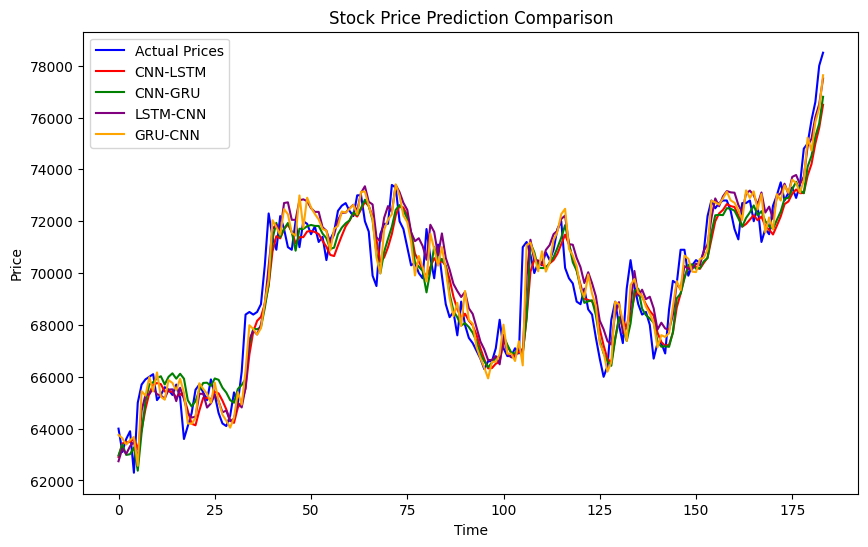

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, color='blue', label='Actual Prices')
plt.plot(y_pred_cnn_lstm, color='red', label='CNN-LSTM')
plt.plot(y_pred_cnn_gru, color='green', label='CNN-GRU')
plt.plot(y_pred_lstm_cnn, color='purple', label='LSTM-CNN')
plt.plot(y_pred_gru_cnn, color='orange', label='GRU-CNN')
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

CNN-LSTM 모델 MAPE: 0.011619987354606946, MAE: 811.5389563519024, RMSE: 1035.4773747233971
CNN-GRU 모델 MAPE: 0.01124091359148298, MAE: 782.7637567934786, RMSE: 1018.3583878238405
LSTM-CNN 모델 MAPE: 0.011632344052767035, MAE: 806.960003396739, RMSE: 1028.976557880254
GRU-CNN 모델 MAPE: 0.010259807356763611, MAE: 713.5193189538045, RMSE: 935.2496998783354


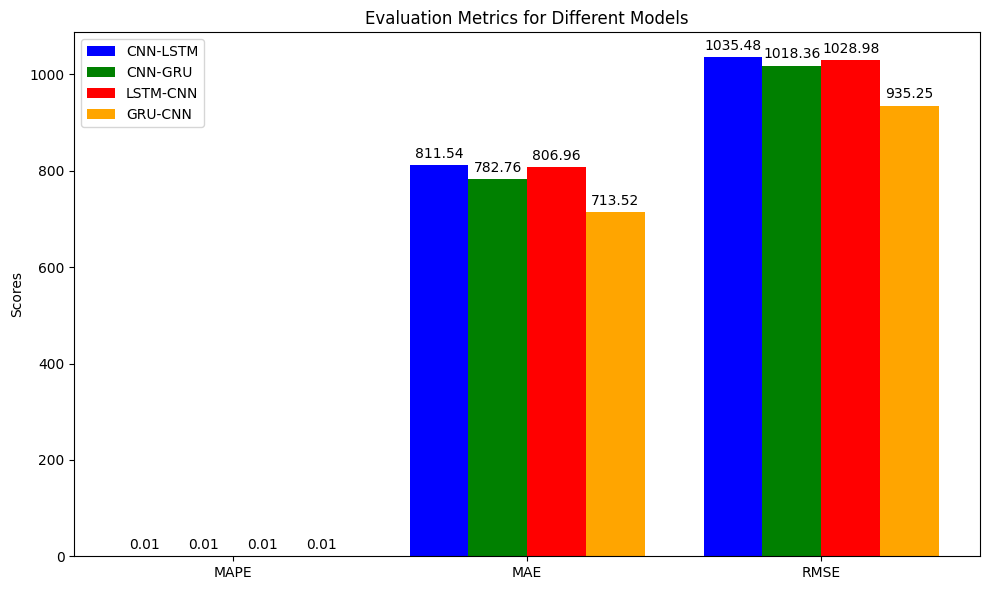

In [ ]:
# 평가 지표 계산
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_rmae(y_true, y_pred):
    return np.sqrt(np.mean(np.abs(y_true - y_pred)))

# MAPE, RMAE, RMSE 계산
mape_cnn_lstm = mean_absolute_percentage_error(y_test_original, y_pred_cnn_lstm)
rmae_cnn_lstm = calculate_rmae(y_test_original, y_pred_cnn_lstm)
rmse_cnn_lstm = calculate_rmse(y_test_original, y_pred_cnn_lstm)

mape_cnn_gru = mean_absolute_percentage_error(y_test_original, y_pred_cnn_gru)
rmae_cnn_gru = calculate_rmae(y_test_original, y_pred_cnn_gru)
rmse_cnn_gru = calculate_rmse(y_test_original, y_pred_cnn_gru)

mape_lstm_cnn = mean_absolute_percentage_error(y_test_original, y_pred_lstm_cnn)
rmae_lstm_cnn = calculate_rmae(y_test_original, y_pred_lstm_cnn)
rmse_lstm_cnn = calculate_rmse(y_test_original, y_pred_lstm_cnn)

mape_gru_cnn = mean_absolute_percentage_error(y_test_original, y_pred_gru_cnn)
rmae_gru_cnn = calculate_rmae(y_test_original, y_pred_gru_cnn)
rmse_gru_cnn = calculate_rmse(y_test_original, y_pred_gru_cnn)

# 출력
print(f"CNN-LSTM 모델 MAPE: {mape_cnn_lstm}, MAE: {mae_cnn_lstm}, RMSE: {rmse_cnn_lstm}")
print(f"CNN-GRU 모델 MAPE: {mape_cnn_gru}, MAE: {mae_cnn_gru}, RMSE: {rmse_cnn_gru}")
print(f"LSTM-CNN 모델 MAPE: {mape_lstm_cnn}, MAE: {mae_lstm_cnn}, RMSE: {rmse_lstm_cnn}")
print(f"GRU-CNN 모델 MAPE: {mape_gru_cnn}, MAE: {mae_gru_cnn}, RMSE: {rmse_gru_cnn}")

# 막대 그래프
evaluation_metrics = ['MAPE', 'MAE', 'RMSE']
cnn_lstm_scores = [mape_cnn_lstm, mae_cnn_lstm, rmse_cnn_lstm]
cnn_gru_scores = [mape_cnn_gru, mae_cnn_gru, rmse_cnn_gru]
lstm_cnn_scores = [mape_lstm_cnn, mae_lstm_cnn, rmse_lstm_cnn]
gru_cnn_scores = [mape_gru_cnn, mae_gru_cnn, rmse_gru_cnn]

x = np.arange(len(evaluation_metrics))  # x축 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(10, 6))

# 평가 지표에 따른 각 모델의 막대 그래프 그리기
rects1 = ax.bar(x - width * 1.5, cnn_lstm_scores, width, label='CNN-LSTM', color='blue')
rects2 = ax.bar(x - width * 0.5, cnn_gru_scores, width, label='CNN-GRU', color='green')
rects3 = ax.bar(x + width * 0.5, lstm_cnn_scores, width, label='LSTM-CNN', color='red')
rects4 = ax.bar(x + width * 1.5, gru_cnn_scores, width, label='GRU-CNN', color='orange')

# 그래프 꾸미기
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(evaluation_metrics)
ax.legend()

# 막대에 숫자 표시
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 포인트 위로 이동
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

plt.tight_layout()
plt.show()